<font color='black' size=6 face='Times New Roman'>Решение соревнования kaggle "Porn Detection" by <b>Safronenkov R. S.</b></font>

<a href=https://www.kaggle.com/c/parkml2020>Park 2020. Porn detection.</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import pymorphy2
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tqdm import notebook

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
seed = 5 # оно тоже дало свой прирост
np.random.seed(seed)

In [3]:
def tokenize_text(text): # простой токенизатор, без знаков препинания
    return re.findall(r'[\w]+', text.lower())

def tokenize_corpus(corpus): # для удобства токенизации всего корпуса
    return [tokenize_text(text) for text in notebook.tqdm(corpus)]

def join_tokenized_sentences(tokenized_sentences): # соединить токенизированный корпус обратно
    sentence_list = []
    for doc in notebook.tqdm(tokenized_sentences):
        sentence = str()
        for token in doc:
            sentence += token + ' '
        sentence_list.append(sentence.rstrip())
    return sentence_list

def lemmatize(token): # лемматизация с использованием pymorphy2
    if lemmatizer.word_is_known(token):
        if token not in lemmatizer_cache:
            lemmatizer_cache[token] = lemmatizer.parse(token)[0].normal_form
        return lemmatizer_cache[token]
    return token

In [4]:
df_train = pd.read_csv("./data/train.csv")

df_train.head()

,id,url,title,target
0,0,m.kp.md,"Экс-министр экономики Молдовы - главе МИДЭИ, ц...",False
1,1,www.kp.by,Эта песня стала известна многим телезрителям б...,False
2,2,fanserials.tv,Банши 4 сезон 2 серия Бремя красоты смотреть о...,False
3,3,colorbox.spb.ru,Не Беси Меня Картинки,False
4,4,tula-sport.ru,В Новомосковске сыграют следж-хоккеисты алекси...,False


In [5]:
test_df = pd.read_csv("./data/test.csv")

test_df.head()

,id,url,title
0,135309,www.kommersant.ru,Шестой кассационный суд в Самаре начнет работу...
1,135310,urexpert.online,"Что такое индексация алиментов, кем и в каких ..."
2,135311,imperimeha.ru,Женщинам | Империя Меха - Part 12
3,135312,national-porn.com,"Небритые, волосатые киски: Порно всех стран и ..."
4,135313,2gis.ru,67


In [6]:
train_df, val_df, tar_train, tar_val = train_test_split(df_train.drop('target', axis=1), df_train.target,
                                                  test_size=0.2, random_state=seed)

In [7]:
train_df = train_df.join(tar_train)
val_df = val_df.join(tar_val)

In [8]:
train_df.shape, val_df.shape

((108247, 4), (27062, 4))

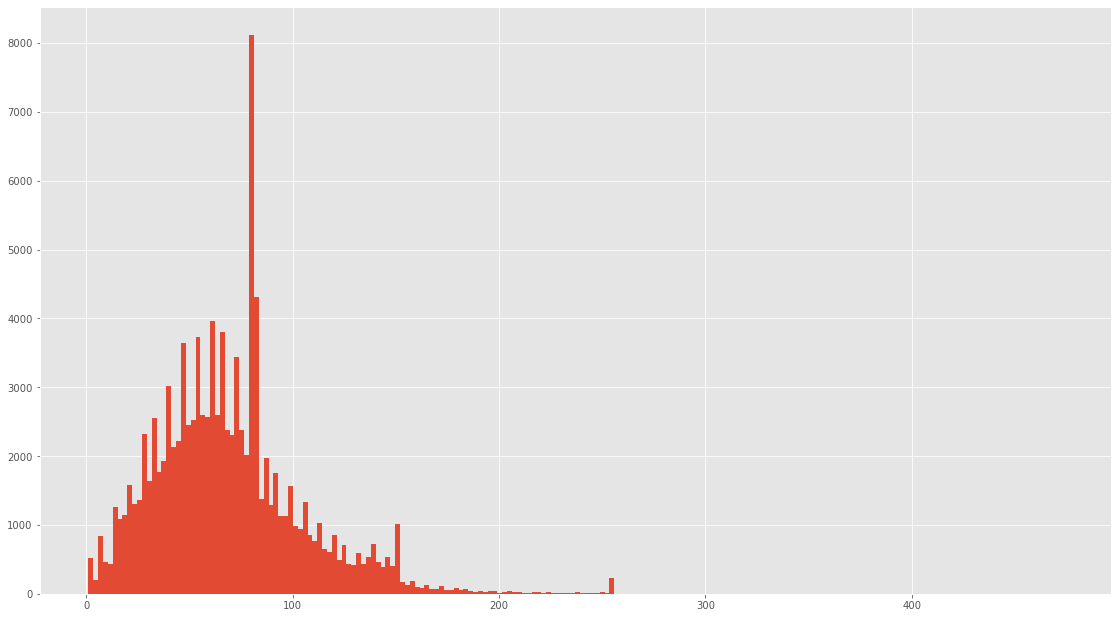

In [9]:
train_df.title.str.len().hist(bins=200, figsize=(19.20, 10.80))
plt.show()

<font color='black' size=6 face='Times New Roman'><b>Токенизация</b></font>

In [10]:
train_df["target"].value_counts()

False    94958
True     13289
Name: target, dtype: int64

In [11]:
corpus_train = train_df.title.values
corpus_val = val_df.title.values
corpus_test = test_df.title.values
corpus_train

array(['Уточнение запроса поиска маршрута',
       'Эбби Грин - Недотрога читать онлайн',
       'Как сделать домик для детей своими руками. Детский домик своими руками. Фото и идеи',
       ..., '10 признаков хорошего детского гастроэнтеролога',
       'Слава героя и поэта в сравнении с заслугой лесовода тускнеет. Ф. Шиллер',
       'Куртки для мальчиков — страница 3, Дочки и Сыночки'], dtype=object)

In [12]:
docs_train = tokenize_corpus(corpus_train)
docs_val = tokenize_corpus(corpus_val)
docs_test = tokenize_corpus(corpus_test)

<font color='black' size=6 face='Times New Roman'><b>Стоп слова</b></font>

In [17]:
occurence = Counter()

for doc in notebook.tqdm(docs_train):
    for token in doc:
        occurence[token] += 1

In [18]:
occurence.most_common(20)

[('в', 30076),
 ('на', 18324),
 ('и', 18275),
 ('ru', 11271),
 ('онлайн', 9664),
 ('с', 8968),
 ('для', 8064),
 ('по', 6781),
 ('бесплатно', 6648),
 ('скачать', 6190),
 ('1', 5592),
 ('mail', 5446),
 ('2', 5123),
 ('купить', 5085),
 ('фото', 5073),
 ('страница', 4645),
 ('4', 4577),
 ('смотреть', 4489),
 ('от', 4266),
 ('поиск', 4222)]

In [19]:
cooccurence = Counter()

for doc in notebook.tqdm(docs_train):
    for i in range(len(doc) - 1):
        cooccurence[(doc[i], doc[i + 1])] += 1

In [20]:
cooccurence.most_common(20)

[(('mail', 'ru'), 5364),
 (('смотреть', 'онлайн'), 3085),
 (('поиск', 'mail'), 2778),
 (('результатов', 'поиск'), 2087),
 (('4', '4'), 1734),
 (('купить', 'в'), 1678),
 (('скачать', 'бесплатно'), 1649),
 (('онлайн', 'бесплатно'), 1582),
 (('читать', 'онлайн'), 1457),
 (('в', 'хорошем'), 1329),
 (('тыс', 'результатов'), 1282),
 (('порно', 'видео'), 1214),
 (('в', 'интернет'), 1207),
 (('в', 'москве'), 1197),
 (('хорошем', 'качестве'), 1115),
 (('интернет', 'магазине'), 1111),
 (('интернет', 'магазин'), 1105),
 (('бесплатно', 'в'), 1059),
 (('на', 'olx'), 1027),
 (('мой', 'мир'), 912)]

In [21]:
N = sum(occurence.values())

In [22]:
pmi = Counter()
min_cooccur = 5

for pair in cooccurence:
    if cooccurence[pair] >= min_cooccur:
        pmi[pair] = np.log(cooccurence[pair] * N / occurence[pair[0]] / occurence[pair[1]])

In [23]:
pmi.most_common(20)

[(('xarid', 'qilish'), 12.308283506228321),
 (('camila', 'cabello'), 12.308283506228321),
 (('змінами', 'перевірено'), 12.308283506228321),
 (('країна', 'майстрів'), 12.308283506228321),
 (('посети', 'мирок'), 12.308283506228321),
 (('саудовской', 'аравии'), 12.308283506228321),
 (('ingyenes', 'pornу'), 12.308283506228321),
 (('pornу', 'videуk'), 12.308283506228321),
 (('xander', 'corvus'), 12.308283506228321),
 (('filmux', 'naujausi'), 12.308283506228321),
 (('shiq', 'matni'), 12.308283506228321),
 (('фгбну', 'внииспк'), 12.308283506228321),
 (('nowy', 'styl'), 12.308283506228321),
 (('sosyal', 'tanışma'), 12.125961949434366),
 (('джудит', 'макнот'), 12.125961949434366),
 (('komplett', 'zusehen'), 12.125961949434366),
 (('zusehen', 'alleserien'), 12.125961949434366),
 (('ганг', 'банг'), 12.125961949434366),
 (('bottega', 'veneta'), 12.125961949434366),
 (('enrique', 'iglesias'), 12.125961949434366)]

<font color='black' size=6 face='Times New Roman'><b>Лемматизация</b></font>

In [24]:
stopwords = nltk.corpus.stopwords.words('russian')
stopwords.extend(nltk.corpus.stopwords.words('english'))
stopwords_set = set(stopwords)

In [25]:
lemmatizer = pymorphy2.MorphAnalyzer()

In [26]:
lemmatizer_cache = {}
lemmatized_docs_train = [[lemmatize(token) for token in text] for text in notebook.tqdm(docs_train)]

cleared_docs_train = [[token for token in text if token not in stopwords_set] for text in lemmatized_docs_train]

In [27]:
lemmatizer_cache = {}
lemmatized_docs_val = [[lemmatize(token) for token in text] for text in notebook.tqdm(docs_val)]

cleared_docs_val = [[token for token in text if token not in stopwords_set] for text in lemmatized_docs_val]

In [28]:
lemmatizer_cache = {}
lemmatized_docs_test = [[lemmatize(token) for token in text] for text in notebook.tqdm(docs_test)]

cleared_docs_test = [[token for token in text if token not in stopwords_set] for text in lemmatized_docs_test]

In [29]:
cleared_docs_train[0]

['уточнение', 'запрос', 'поиск', 'маршрут']

In [30]:
cleared_docs_val[0]

['скин', 'каталог', 'файл', 'dav1dmods', 'мода', 'для', 'gta', 'sa']

In [31]:
train_df.sample(5)

,id,url,title,target
78684,78684,www.yaplakal.com,ЯПлакалъ - Профиль пользователя,False
54131,54131,mail.ru,Audi показала новый кроссовер – он похож на сп...,False
129470,129470,www.mamba.ru,"Владимир, 44, Воронеж",False
113652,113652,rutorgame.org,Скачать Severance: Blade of Darkness торрент б...,False
126121,126121,uldelo.ru,Деловое обозрение | Материалы тэга афиша,False


<font color='black' size=5 face='Times New Roman'>Соединяю разделенные предложения обратно, для удобства их передачи в pipeline</font>

In [32]:
sentence_list_train = join_tokenized_sentences(cleared_docs_train)
sentence_list_val = join_tokenized_sentences(cleared_docs_val)
sentence_list_test = join_tokenized_sentences(cleared_docs_test)

In [33]:
train_df['title'] = sentence_list_train
val_df['title'] = sentence_list_val
test_df['title'] = sentence_list_test

In [34]:
train_df.sample(5)

,id,url,title,target
114152,114152,www.orgpage.ru,ломбард около метро текстильщик москва,False
116116,116116,hdrezkaag.net,смотреть русский фильм боевик бесплатно в хоро...,False
85642,85642,olx.uz,требоваться кассир оператор и водитель с свой ...,False
28143,28143,www.lecheniye-alkogolizma.ru,наркологический клиника наркоздрав,False
60322,60322,piratam.net,true remembrance истина память vnshiba satomia...,False


In [35]:
y_train = train_df["target"].astype(int).values
y_val = val_df["target"].astype(int).values

<font color='black' size=6 face='Times New Roman'><b>Обучение модели</b></font>

In [36]:
class ColumnExtractor(TransformerMixin): # для того, чтобы сшивать фичи
    
    def __init__(self, column_name):
        self.column_name = column_name
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.column_name].values

In [46]:
from sklearn.model_selection import RandomizedSearchCV

In [42]:
model = VotingClassifier(estimators = [('forest', RandomForestClassifier(n_estimators=100,
                                                                         min_samples_leaf=1,
                                                                         random_state=seed,
                                                                         max_depth=200,
                                                                         max_features='sqrt', # корень из кол-ва фичей 
                                                                         n_jobs=-1)),
                                       ('logreg', LogisticRegression(solver='liblinear',
                                                                     C=5.0,
                                                                     random_state=seed)),
#                                        ('bayes', MultinomialNB())], # с ним хуже
                                      ],
                         voting='soft',
                         n_jobs=-1)

In [43]:
pipeline = Pipeline([
    (
        'features', 
        FeatureUnion([
            (
                'url', 
                Pipeline([
                    ('extractor', ColumnExtractor('url')),
                    (
                        'vectorizer', 
                        TfidfVectorizer( # 2-6-граммы, выше 90% и меньше 5 удаляю
                            lowercase=True, ngram_range=(2, 6),
                            stop_words=stopwords_set, min_df=5, max_df=0.9, analyzer='char' 
                        )
                    )
                ])
            ),
            (
                'title',
                Pipeline([
                    ('extractor', ColumnExtractor('title')),
                    (
                        'vectorizer', 
                        CountVectorizer( # единичные слова, выше 90% и меньше 5 удаляю
                            lowercase=True, ngram_range=(1, 1),
                            stop_words=stopwords_set, min_df=5, max_df=0.75
                        )
                    )
                ]),
            ),
        ])
    ),
    ('clf', model)
])

In [53]:
from sklearn.metrics import make_scorer

f1 = make_scorer(f1_score , average='macro')

In [58]:
params = {'clf__forest__n_estimators': range(100, 200, 10),
          'clf__forest__max_depth': range(10, 200, 10),
          'clf__forest__max_features': ["auto", "sqrt", "log2"],
#           'clf__logreg__C': range(0.1, 5, 0.1),
          'clf__logreg__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
searcher = RandomizedSearchCV(pipeline, param_distributions=params, n_jobs=-1, scoring=f1, random_state=seed)

In [ ]:
searcher.fit(train_df, y_train)

In [ ]:
searcher.best_params_

In [44]:
%%time

pipeline.fit(train_df, y_train)

Wall time: 2min 11s


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('url',
                                                 Pipeline(steps=[('extractor',
                                                                  <__main__.ColumnExtractor object at 0x000001FB5184F348>),
                                                                 ('vectorizer',
                                                                  TfidfVectorizer(analyzer='char',
                                                                                  max_df=0.9,
                                                                                  min_df=5,
                                                                                  ngram_range=(2,
                                                                                               6),
                                                                                  stop_words=set()))])),
                                             

In [45]:
print('Train score = {}, val score = {}'.format(f1_score(y_train, pipeline.predict(train_df)),
                                                f1_score(y_val, pipeline.predict(val_df))))

Train score = 0.996640368427013, val score = 0.9851054416752691


<font color='black' size=6 face='Times New Roman'><b>Submit</b></font>

In [98]:
test_df["target"] = pipeline.predict(test_df).astype(bool)

test_df[["id", "target"]].to_csv("./data/submission.csv", index=False)

In [99]:
test_df[test_df.target == True].sample(5)

,id,url,title,target
160918,296227,porno-vik.ru,обнажённый зрелый сучка присесть и распахнуть ...,True
91860,227169,biqle.com,милашка играть с свой дырочка amateur solo web...,True
45499,180808,amatorskoe.org,частный секс втроём с русский молодой девушка ...,True
54915,190224,porno-tour.xxx,свинегры ебут красавица и кончать на язык блядь,True
47000,182309,www.pornktube.porn,search videos for faimely affair,True


In [100]:
test_df[test_df.target == True].shape # в лучшей попытке было 19989

(20012, 4)

<font color='black' size=4 face='Times New Roman'>Максимально чего добивался на валидации <b>0.9861601884570081</b>, получилось с помощью классификатора с голосованием, состоящего из <b>случайного леса</b> и <b>логистической регрессии</b> с ослабленной регуляризацией. Увеличение колличества деревьев от 100 и выше, ухудшало модель, видимо делало её слишком сложной, ровно как и увеличение коэффициента C в логистической регрессии. Попытки добавить другие классификаторы не увенчались успехом, Наивный Байес ухудшает модель, а другие (SVM и KNN), работают очень медленно на больших данных. В качестве преобработки я выбрал <b>2-6-граммы для URL и Tfidf</b>, просто слова для <b>Title с CountVectorizer</b>, предварительно лемматизировав и удалив стоп слова. Для Title Tfidf показал худшие результаты, ровно как и использование n-грамм. Сделал <b>word2vec</b> для title, наблюдалось сильное переобучение, при том не было существенных увеличений качества на тренировочной выборке, в связи с этим решил не использовать его.</font>